# Question 1


Results for β = 0.1
Retarded time (s): -4.159423221934734e-11
Source position at t_r (cm): [-0.12469637  0.          0.        ]
R vector (cm): [1.12469637 0.5        0.2       ]
R (cm): 1.246973106082423
E field (statV/cm): [0.67798065 0.33899065 0.13559626]
B field (gauss): [-6.93889390e-18 -1.35596258e-02  3.38990646e-02]
gamma: 1.00504,  n·β: 0.09019


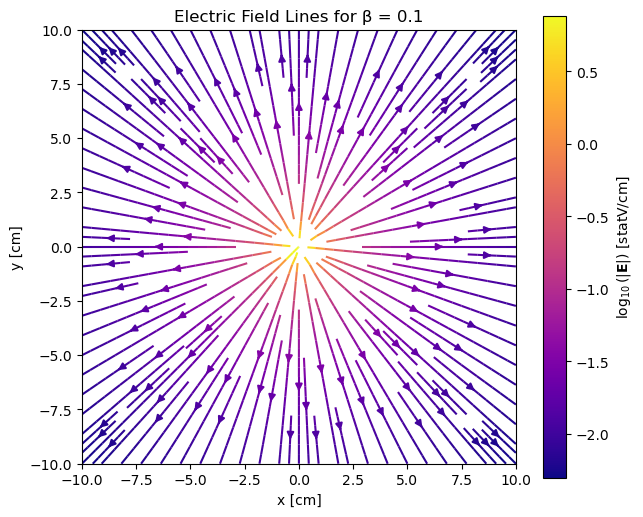


Results for β = 0.9
Retarded time (s): -3.381953705705485e-10
Source position at t_r (cm): [-9.12495793  0.          0.        ]
R vector (cm): [10.12495793  0.5         0.2       ]
R (cm): 10.139268861880934
E field (statV/cm): [0.17543679 0.08775209 0.03510084]
B field (gauss): [ 0.         -0.03159075  0.07897688]
gamma: 2.29416,  n·β: 0.89873


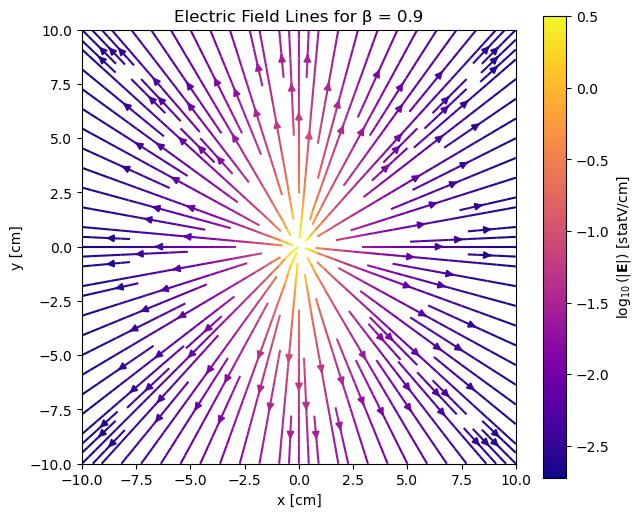


Results for β = 0.999
Retarded time (s): -3.3361194736370216e-08
Source position at t_r (cm): [-999.14331373    0.            0.        ]
R vector (cm): [1.00014331e+03 5.00000000e-01 2.00000000e-01]
R (cm): 1000.1434587053376
E field (statV/cm): [0.00199727 0.00099864 0.00039945]
B field (gauss): [ 0.         -0.00039905  0.00099764]
gamma: 22.36627,  n·β: 0.99900


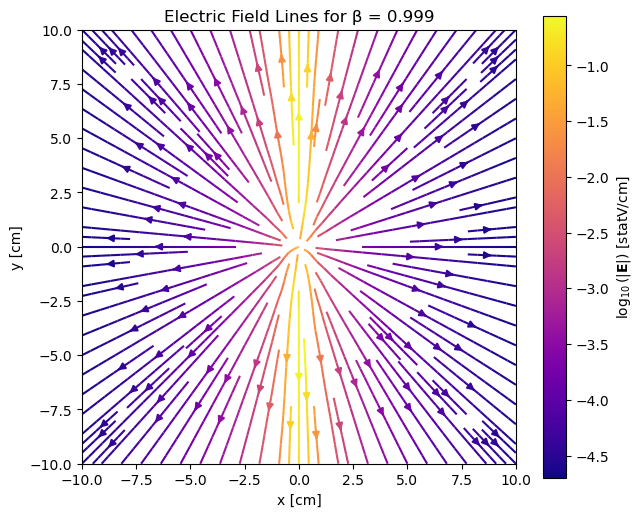

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Physical constant (Gaussian units) ---
c = 2.99792458e10  # cm/s

# ---------------------------------------------------
# 1. Retarded time solver (Newton iteration)
# ---------------------------------------------------
def retarded_time_uniform(r_field, t_obs, r0, v, tol=1e-12, max_iter=100):
    """
    Solve t_obs - t_r = |r_field - (r0 + v * t_r)| / c  for t_r.
    Works for constant velocity motion.
    """
    tr = t_obs - np.linalg.norm(r_field - r0) / c  # initial guess
    for _ in range(max_iter):
        rq = r0 + v * tr
        Rvec = r_field - rq
        R = np.linalg.norm(Rvec)
        if R == 0.0:
            raise ValueError("Field point coincides with the charge position.")
        f = t_obs - tr - R / c
        if abs(f) < tol:
            return tr
        df = -1.0 + np.dot(v, Rvec) / (c * R)
        tr = tr - f / (df if abs(df) > 1e-16 else np.sign(df) * 1e-16)
    raise RuntimeError("Retarded time did not converge")

# ---------------------------------------------------
# 2. Electric & Magnetic fields (velocity term only)
# ---------------------------------------------------
def fields_uniform_motion(q, beta, r_field, t_obs, r0=np.zeros(3)):
    """
    Compute E and B at r_field and time t_obs for a charge moving uniformly
    with velocity along +x direction.
    """
    v = np.array([beta * c, 0.0, 0.0])
    tr = retarded_time_uniform(r_field, t_obs, r0, v)
    rq = r0 + v * tr
    Rvec = r_field - rq
    R = np.linalg.norm(Rvec)
    n = Rvec / R
    beta_vec = v / c
    n_dot_beta = np.dot(n, beta_vec)
    gamma = 1.0 / np.sqrt(1.0 - np.dot(beta_vec, beta_vec))
    
    # Electric field (velocity term)
    E = q * (n - beta_vec) / (gamma**2 * (1 - n_dot_beta)**3 * R**2)
    # Magnetic field
    B = np.cross(n, E)
    
    return {
        "tr": tr,
        "rq": rq,
        "Rvec": Rvec,
        "R": R,
        "n": n,
        "E": E,
        "B": B,
        "gamma": gamma,
        "n_dot_beta": n_dot_beta
    }

# ---------------------------------------------------
# 3. Plot field lines (XY plane)
# ---------------------------------------------------
def plot_field_lines(q=1.0, beta=0.9, t_obs=0.0, grid_size=40, L=10, savefig=False):
    x = np.linspace(-L, L, grid_size)
    y = np.linspace(-L, L, grid_size)
    X, Y = np.meshgrid(x, y)
    Ex, Ey = np.zeros_like(X), np.zeros_like(Y)
    
    for i in range(grid_size):
        for j in range(grid_size):
            r_field = np.array([X[i, j], Y[i, j], 0.0])
            E = fields_uniform_motion(q, beta, r_field, t_obs)["E"]
            Ex[i, j], Ey[i, j] = E[0], E[1]
    
    E_mag = np.sqrt(Ex**2 + Ey**2)
    plt.figure(figsize=(7, 6))
    plt.streamplot(X, Y, Ex, Ey, color=np.log10(E_mag + 1e-20),
                   cmap='plasma', density=1.5)
    plt.colorbar(label=r'$\log_{10}(|\mathbf{E}|)$ [statV/cm]')
    plt.title(f"Electric Field Lines for β = {beta}")
    plt.xlabel("x [cm]")
    plt.ylabel("y [cm]")
    plt.gca().set_aspect('equal', 'box')
    if savefig:
        plt.savefig(f"field_beta_{str(beta).replace('.','')}.png", dpi=300, bbox_inches='tight')
    plt.show()

# ---------------------------------------------------
# 4. Run examples for β = 0.1, 0.9, 0.999
# ---------------------------------------------------
if __name__ == "__main__":
    q = 1.0
    r_field = np.array([1.0, 0.5, 0.2])  # field point (cm)
    t_obs = 0.0
    betas = [0.1, 0.9, 0.999]
    
    for b in betas:
        print(f"\n==============================")
        print(f"Results for β = {b}")
        print(f"==============================")
        out = fields_uniform_motion(q, b, r_field, t_obs)
        print(f"Retarded time (s): {out['tr']}")
        print(f"Source position at t_r (cm): {out['rq']}")
        print(f"R vector (cm): {out['Rvec']}")
        print(f"R (cm): {out['R']}")
        print(f"E field (statV/cm): {out['E']}")
        print(f"B field (gauss): {out['B']}")
        print(f"gamma: {out['gamma']:.5f},  n·β: {out['n_dot_beta']:.5f}")
        
        # Generate field-line plot
        plot_field_lines(q=q, beta=b, L=10, grid_size=40, savefig=True)


# Question 2


=== Radiation Field Calculation Results (Sample at t=0.1 s) ===

β₀ = 0.1, Case A: a = 0.3 along z
Retarded time (s): 0.0908327426039359
Source position at t_r (cm): [2.72309712e+08 0.00000000e+00 3.71019569e+07]
R vector (cm): [-2.72309712e+08  1.00000000e+06 -3.71019569e+07]
R magnitude (cm): 274827462.793825
E_rad (statV/cm): [ 3.99844903e-21 -1.33373903e-23 -2.93469653e-20]
B_rad (gauss): [-1.08583794e-22 -2.96179059e-20 -1.33373903e-24]
---------------------------------------------------------------------------
β₀ = 0.1, Case B: a = 0.9 along x
Retarded time (s): 0.08775841951482678
Source position at t_r (cm): [3.66991988e+08 0.00000000e+00 0.00000000e+00]
R vector (cm): [-3.66991988e+08  1.00000000e+06  0.00000000e+00]
R magnitude (cm): 366993350.3454914
E_rad (statV/cm): [-3.70617390e-25 -1.36013613e-22 -0.00000000e+00]
B_rad (gauss): [ 0.00000000e+00 -0.00000000e+00  1.36014118e-22]
---------------------------------------------------------------------------
β₀ = 0.9, Case A: 

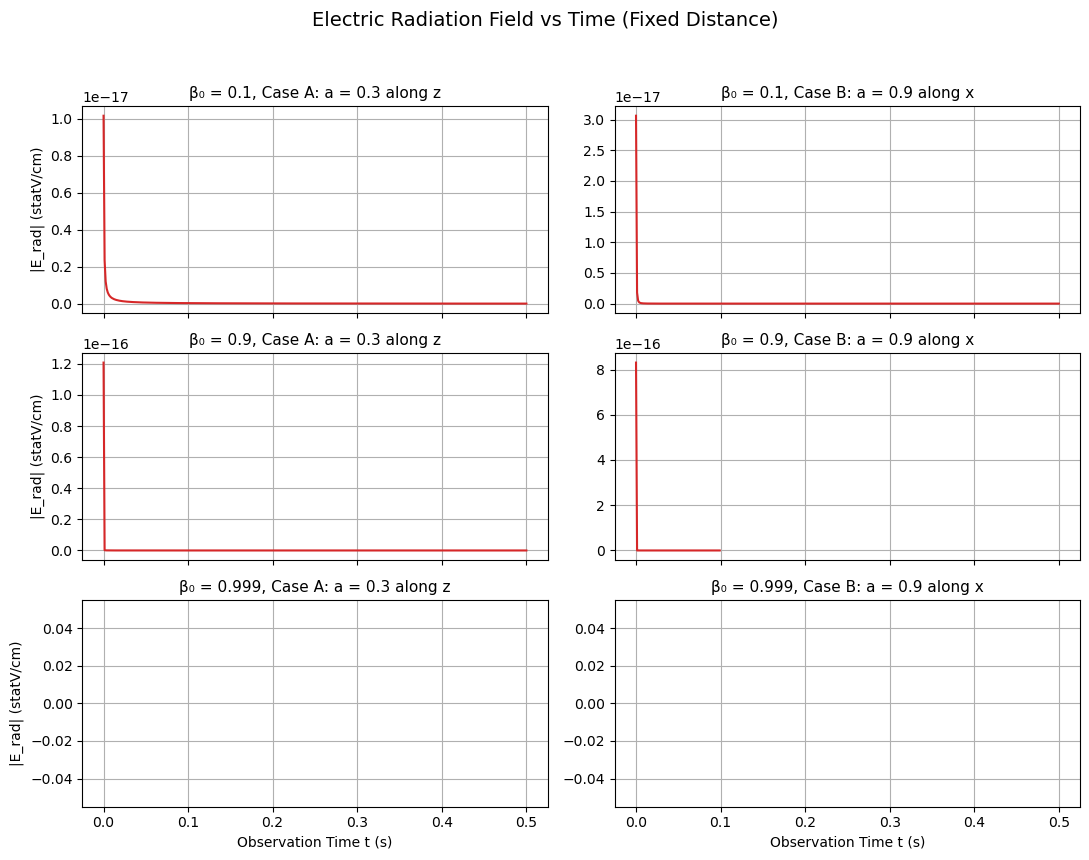

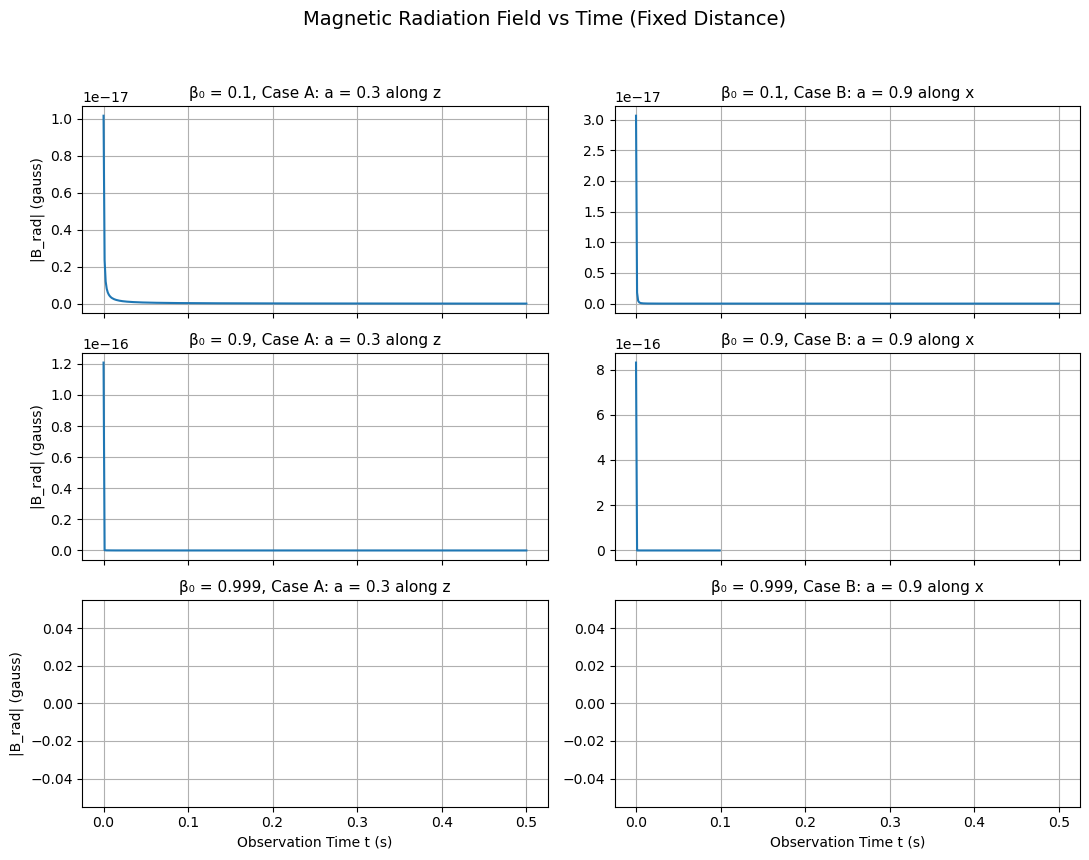

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Constants --------------------
c = 2.99792458e10  # cm/s

# -------------------- Retarded time solver --------------------
def retarded_time(r_field, t_obs, r_of_t, v_of_t, tol=1e-12, max_iter=100):
    """Solve t_obs - t_r = |r_field - r_q(t_r)| / c using Newton's method."""
    tr = t_obs - np.linalg.norm(r_field - r_of_t(0.0)) / c
    for _ in range(max_iter):
        rq = r_of_t(tr)
        vq = v_of_t(tr)
        Rvec = r_field - rq
        R = np.linalg.norm(Rvec)
        f = t_obs - tr - R / c
        if abs(f) < tol:
            return tr
        df = -1 + np.dot(vq, Rvec) / (c * R)
        tr -= f / (df if abs(df) > 1e-16 else np.sign(df) * 1e-16)
    raise RuntimeError("Retarded-time solver did not converge")

# -------------------- Radiation fields (1/R term) --------------------
def radiation_fields_full(q, betadot_vec, r_field, t_obs, r_of_t, v_of_t):
    """Compute E_rad and B_rad using Liénard–Wiechert radiation term."""
    tr = retarded_time(r_field, t_obs, r_of_t, v_of_t)
    rq = r_of_t(tr)
    vq = v_of_t(tr)
    Rvec = r_field - rq
    R = np.linalg.norm(Rvec)
    n = Rvec / R
    beta = vq / c
    n_dot_beta = np.dot(n, beta)
    numer = np.cross(n, np.cross((n - beta), betadot_vec))
    E_rad = (q / c) * numer / ((1 - n_dot_beta)**3 * R)
    B_rad = np.cross(n, E_rad)
    return E_rad, B_rad, tr, rq, Rvec, R

def make_uniform_accel(beta0_vec, betadot_vec, r0=np.zeros(3)):
    def r_of_t(t):
        return r0 + c * (beta0_vec * t + 0.5 * betadot_vec * t**2)
    def v_of_t(t):
        return c * (beta0_vec + betadot_vec * t)
    return r_of_t, v_of_t

def simulate_field_vs_time(q, beta0, betadot_vec,
                           R0=1e6, n_obs=np.array([0.0,1.0,0.0]),
                           Tmax=0.5, N=300):
    beta0_vec = np.array([beta0, 0.0, 0.0])
    r_of_t, v_of_t = make_uniform_accel(beta0_vec, betadot_vec)
    r_field = n_obs * R0
    times = np.linspace(0, Tmax, N)
    E_mag = np.zeros(N)
    B_mag = np.zeros(N)
    for i, t_obs in enumerate(times):
        beta_t = beta0_vec + betadot_vec * t_obs
        if np.linalg.norm(beta_t) >= 0.99:
            E_mag = E_mag[:i]; B_mag = B_mag[:i]; times = times[:i]
            break
        E_rad, B_rad, *_ = radiation_fields_full(q, betadot_vec, r_field, t_obs, r_of_t, v_of_t)
        E_mag[i] = np.linalg.norm(E_rad)
        B_mag[i] = np.linalg.norm(B_rad)
    return times, E_mag, B_mag

def run_all_cases():
    q = 1.0
    betas = [0.1, 0.9, 0.999]
    accel_cases = {
        "Case A: a = 0.3 along z": np.array([0.0, 0.0, 0.3]),
        "Case B: a = 0.9 along x": np.array([0.9, 0.0, 0.0])
    }
    R0 = 1e6
    n_obs = np.array([0.0, 1.0, 0.0])

    # ---------- Compute and print field values ----------
    print("\n=== Radiation Field Calculation Results (Sample at t=0.1 s) ===\n")
    for beta0 in betas:
        for case_name, betadot_vec in accel_cases.items():
            beta0_vec = np.array([beta0, 0.0, 0.0])
            r_of_t, v_of_t = make_uniform_accel(beta0_vec, betadot_vec)
            r_field = n_obs * R0
            t_obs = 0.1

            E_rad, B_rad, tr, rq, Rvec, R = radiation_fields_full(
                q, betadot_vec, r_field, t_obs, r_of_t, v_of_t
            )

            print(f"β₀ = {beta0}, {case_name}")
            print(f"Retarded time (s): {tr}")
            print(f"Source position at t_r (cm): {rq}")
            print(f"R vector (cm): {Rvec}")
            print(f"R magnitude (cm): {R}")
            print(f"E_rad (statV/cm): {E_rad}")
            print(f"B_rad (gauss): {B_rad}")
            print("-" * 75)

    # ---------- ELECTRIC FIELD PLOTS ----------
    figE, axsE = plt.subplots(len(betas), len(accel_cases),
                              figsize=(11, 9), sharex=True, sharey=False)
    figE.subplots_adjust(hspace=0.35, wspace=0.25)

    for i, beta0 in enumerate(betas):
        for j, (case_name, betadot_vec) in enumerate(accel_cases.items()):
            t, E, B = simulate_field_vs_time(q, beta0, betadot_vec,
                                             R0=R0, n_obs=n_obs,
                                             Tmax=0.5, N=400)
            ax = axsE[i, j]
            ax.plot(t, E, color='tab:red')
            ax.set_title(f"β₀ = {beta0}, {case_name}", fontsize=11)
            ax.grid(True)
            if j == 0:
                ax.set_ylabel('|E_rad| (statV/cm)')
            if i == len(betas)-1:
                ax.set_xlabel('Observation Time t (s)')

    plt.suptitle('Electric Radiation Field vs Time (Fixed Distance)', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('E_Radiation_Field_vs_Time.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ---------- MAGNETIC FIELD PLOTS ----------
    figB, axsB = plt.subplots(len(betas), len(accel_cases),
                              figsize=(11, 9), sharex=True, sharey=False)
    figB.subplots_adjust(hspace=0.35, wspace=0.25)

    for i, beta0 in enumerate(betas):
        for j, (case_name, betadot_vec) in enumerate(accel_cases.items()):
            t, E, B = simulate_field_vs_time(q, beta0, betadot_vec,
                                             R0=R0, n_obs=n_obs,
                                             Tmax=0.5, N=400)
            ax = axsB[i, j]
            ax.plot(t, B, color='tab:blue')
            ax.set_title(f"β₀ = {beta0}, {case_name}", fontsize=11)
            ax.grid(True)
            if j == 0:
                ax.set_ylabel('|B_rad| (gauss)')
            if i == len(betas)-1:
                ax.set_xlabel('Observation Time t (s)')

    plt.suptitle('Magnetic Radiation Field vs Time (Fixed Distance)', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('B_Radiation_Field_vs_Time.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------- Execute --------------------
if __name__ == "__main__":
    run_all_cases()


# Question 3

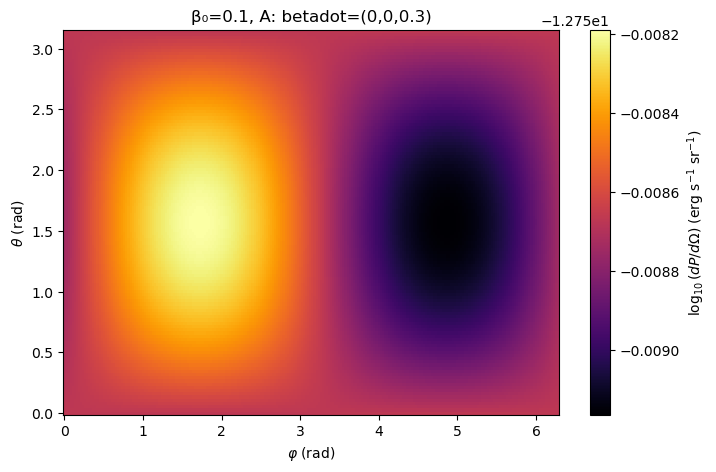

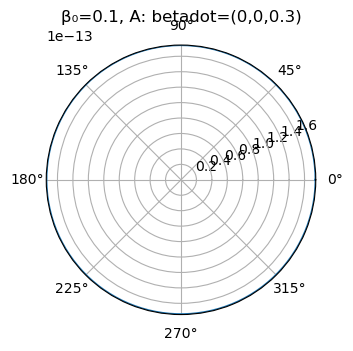

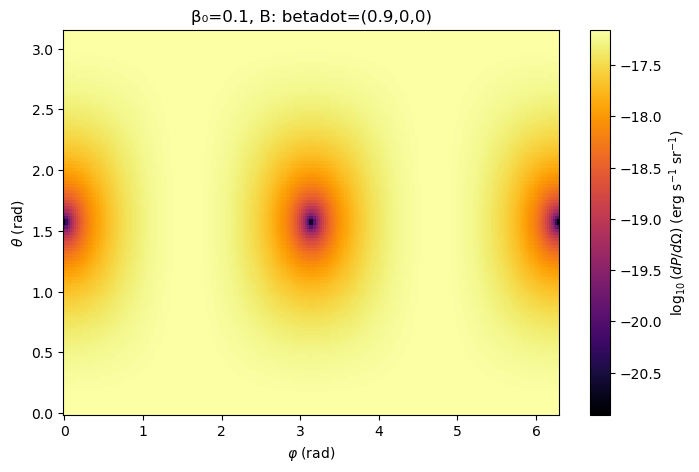

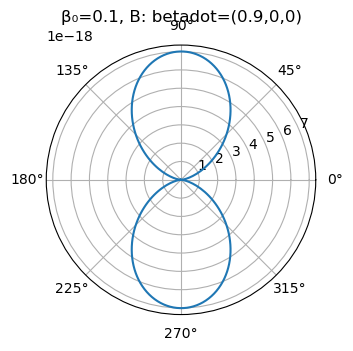

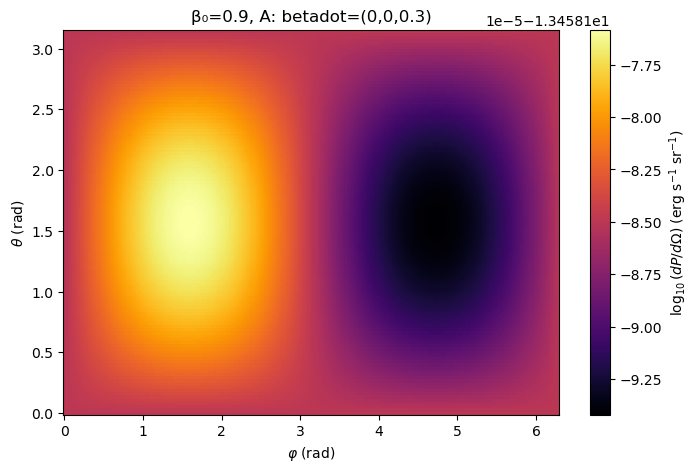

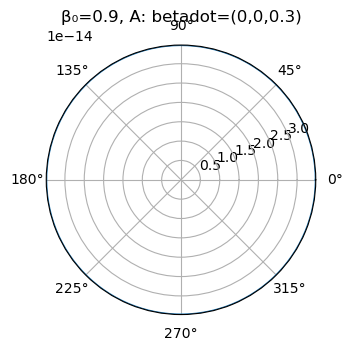

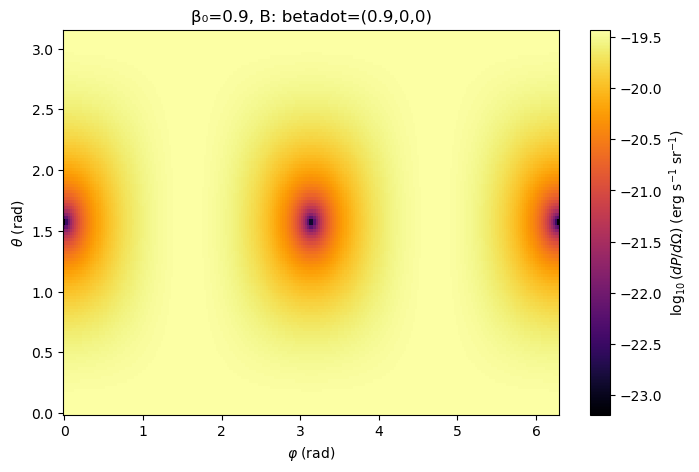

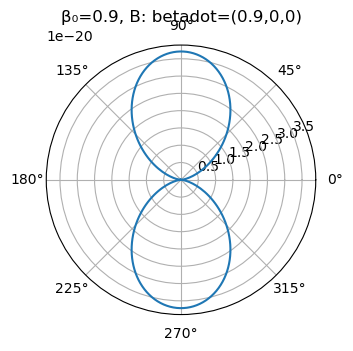

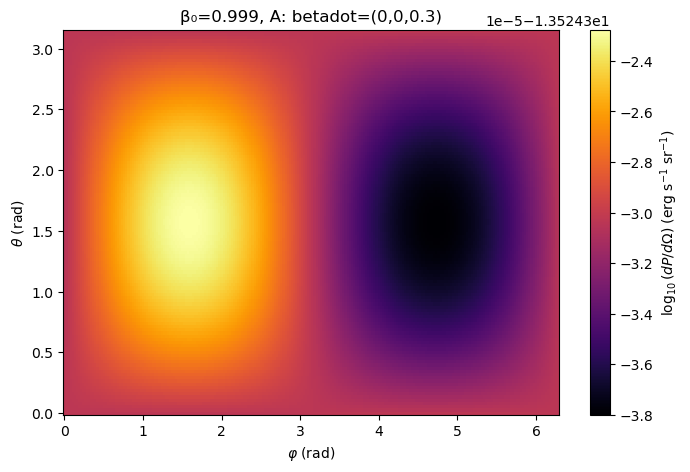

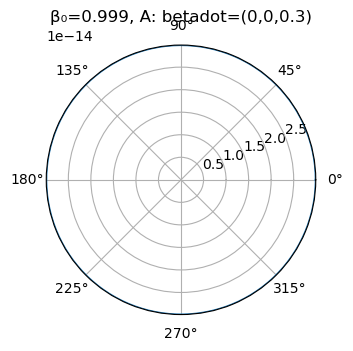

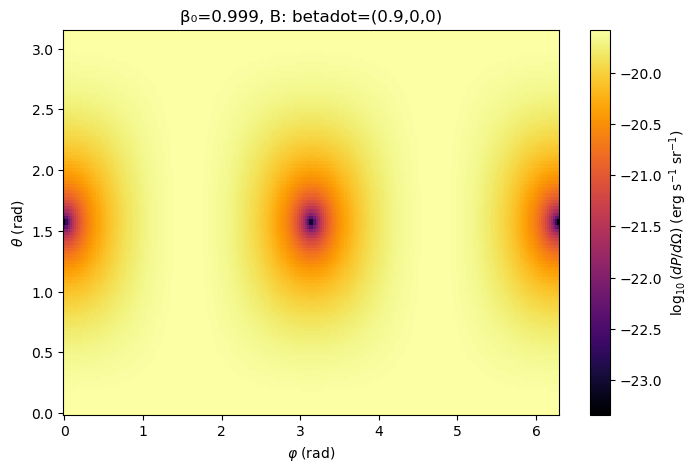

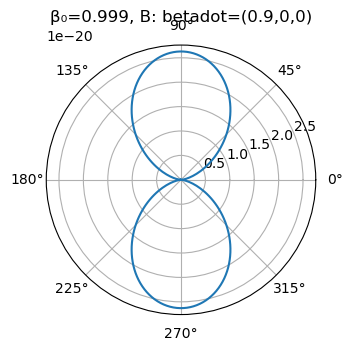


===== Emitted Power per Solid Angle Summary =====

   β₀                 Case  Total Power (erg/s)  Total Power (W)  Peak dP/dΩ (erg/s/sr)  Peak dP/dΩ (W/sr)  θ_peak (°)  φ_peak (°)
0.100 A: betadot=(0,0,0.3)         2.199498e-12     2.199498e-19           1.745061e-13       1.745061e-20   89.243697   97.907950
0.100 B: betadot=(0.9,0,0)         5.882944e-17     5.882944e-24           7.008169e-18       7.008169e-25    3.025210   87.364017
0.900 A: betadot=(0,0,0.3)         4.393523e-13     4.393523e-20           3.481963e-14       3.481963e-21   89.243697   90.376569
0.900 B: betadot=(0.9,0,0)         3.115769e-19     3.115769e-26           3.711732e-20       3.711732e-27    1.512605   88.870293
0.999 A: betadot=(0,0,0.3)         3.772833e-13     3.772833e-20           2.990042e-14       2.990042e-21   89.243697   90.376569
0.999 B: betadot=(0.9,0,0)         2.207347e-19     2.207347e-26           2.629554e-20       2.629554e-27    1.512605   88.870293

Table saved as Radiation_Power

In [21]:
# ---------------- compute field map for visualization ----------------
def generate_field_map(q, beta0, betadot_vec, t_obs=0.1, R0=1e6, n_theta=120, n_phi=240):
    beta0_vec = np.array([beta0, 0.0, 0.0])
    r_of_t, v_of_t = make_uniform_accel(beta0_vec, betadot_vec)
    TH, PH = angular_grid(n_theta, n_phi)
    nvecs = n_from_thphi(TH, PH)
    dP = np.zeros(TH.shape)
    for i in range(TH.shape[0]):
        for j in range(TH.shape[1]):
            n = nvecs[i, j]
            r_field = n * R0
            try:
                dP[i, j] = dPdOmega_direction(q, r_field, t_obs, r_of_t, v_of_t, betadot_vec)
            except Exception:
                dP[i, j] = 0.0
    return TH, PH, dP

# ---------------- compute integrated quantities (for table) ----------------
def compute_angular_pattern(q, beta0, betadot_vec, t_obs=0.1, R0=1e6, n_theta=120, n_phi=240):
    beta0_vec = np.array([beta0, 0.0, 0.0])
    r_of_t, v_of_t = make_uniform_accel(beta0_vec, betadot_vec)
    TH, PH = angular_grid(n_theta, n_phi)
    nvecs = n_from_thphi(TH, PH)
    dP = np.zeros(TH.shape)
    for i in range(TH.shape[0]):
        for j in range(TH.shape[1]):
            n = nvecs[i, j]
            r_field = n * R0
            try:
                dP[i, j] = dPdOmega_direction(q, r_field, t_obs, r_of_t, v_of_t, betadot_vec)
            except Exception:
                dP[i, j] = 0.0
    theta = TH[:, 0]; phi = PH[0, :]
    dtheta = theta[1] - theta[0]; dphi = phi[1] - phi[0]
    total_power = np.sum(dP * np.sin(theta)[:, None]) * dtheta * dphi
    idx = np.unravel_index(np.argmax(dP), dP.shape)
    return total_power, dP[idx], np.degrees(TH[idx]), np.degrees(PH[idx])

# ---------------- main driver ----------------
if __name__ == "__main__":
    q = 1.0
    betas = [0.1, 0.9, 0.999]
    accel_cases = {
        "A: betadot=(0,0,0.3)": np.array([0.0, 0.0, 0.3]),
        "B: betadot=(0.9,0,0)": np.array([0.9, 0.0, 0.0])
    }
    t_obs = 0.1
    R0 = 1e6

    results = []

    for beta0 in betas:
        for case_name, betadot_vec in accel_cases.items():
            # --- generate field map for plotting ---
            TH, PH, dP = generate_field_map(q, beta0, betadot_vec, t_obs=t_obs, R0=R0)
            title = f"β₀={beta0}, {case_name}"
            fname = f"angdist_beta{str(beta0).replace('.','p')}_{'A' if 'A' in case_name else 'B'}.png"
            plot_angular_map(TH, PH, dP, title=title, fname=fname)
            plot_phi_cut(TH, PH, dP, title=title, fname=f"cut_{fname}")

            # --- compute integrated & peak values for table ---
            total_power, peak_value, theta_peak, phi_peak = compute_angular_pattern(q, beta0, betadot_vec)
            results.append({
                "β₀": beta0,
                "Case": case_name,
                "Total Power (erg/s)": total_power,
                "Total Power (W)": total_power * 1e-7,
                "Peak dP/dΩ (erg/s/sr)": peak_value,
                "Peak dP/dΩ (W/sr)": peak_value * 1e-7,
                "θ_peak (°)": theta_peak,
                "φ_peak (°)": phi_peak
            })

    # ---------- print summary table ----------
    df = pd.DataFrame(results)
    print("\n===== Emitted Power per Solid Angle Summary =====\n")
    print(df.to_string(index=False))
    df.to_csv("Radiation_Power_Summary.csv", index=False)
    print("\nTable saved as Radiation_Power_Summary.csv\n")


# Question 4

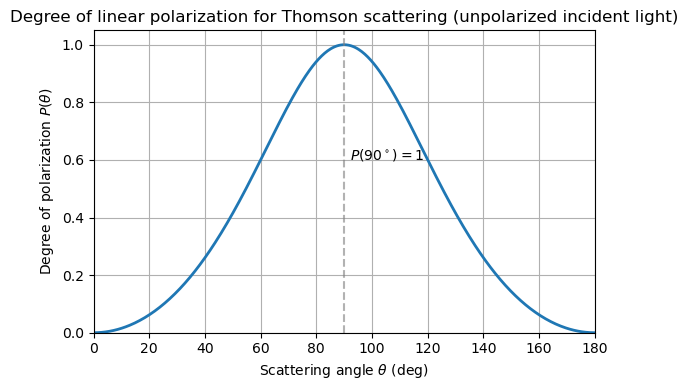

Part (C) -- observer at +y (both beams scatter at 90 deg):
Scattered intensities (relative): I_zpol = 1.000, I_xpol = 0.100
Total scattered intensity (relative): 1.100
Degree of linear polarization: P = 0.818182 (=81.82%)
Net polarization direction: along the stronger component (here: z-direction)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- Polarization function -----------------
def P_theta(theta):
    """Degree of linear polarization for unpolarized incident light scattered at angle theta (radians)."""
    ct = np.cos(theta)
    st2 = (1 - ct**2)  # sin^2
    return st2 / (1 + ct**2)

# -------------- Plot P(theta) 0..pi ----------------
thetas = np.linspace(0, np.pi, 500)
Pvals = P_theta(thetas)

plt.figure(figsize=(6,4))
plt.plot(np.degrees(thetas), Pvals, lw=2)
plt.xlabel(r'Scattering angle $\theta$ (deg)')
plt.ylabel(r'Degree of polarization $P(\theta)$')
plt.title('Degree of linear polarization for Thomson scattering (unpolarized incident light)')
plt.grid(True)
plt.ylim(0,1.05)
plt.xlim(0,180)
plt.axvline(90, color='gray', ls='--', alpha=0.6)
plt.text(92,0.6,"$P(90^\circ)=1$", fontsize=10)
plt.tight_layout()
plt.show()

# -------------- Part (C) numeric for observer along +y --------------
I0 = 1.0        # relative intensity of beam along +x
I1 = I0 / 10.0  # relative intensity of beam along +z

# Both scatter at theta=90 deg -> each contribution is 100% polarized
I_zpol = I0     # from beam along x, polarized along z
I_xpol = I1     # from beam along z, polarized along x

I_total = I_zpol + I_xpol
P_combined = abs(I_zpol - I_xpol) / I_total

print("Part (C) -- observer at +y (both beams scatter at 90 deg):")
print(f"Scattered intensities (relative): I_zpol = {I_zpol:.3f}, I_xpol = {I_xpol:.3f}")
print(f"Total scattered intensity (relative): {I_total:.3f}")
print(f"Degree of linear polarization: P = {P_combined:.6f} (={P_combined*100:.2f}%)")
print("Net polarization direction: along the stronger component (here: z-direction)")


# Question 5

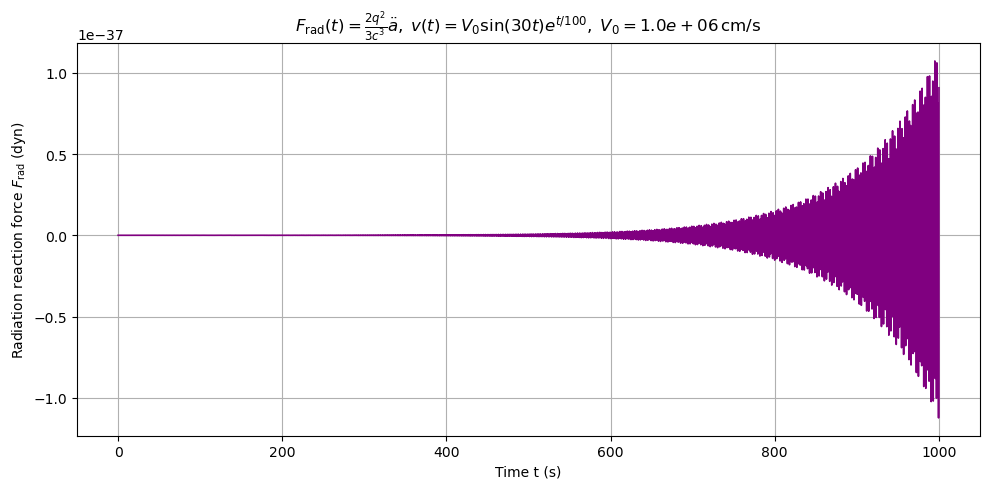

In [25]:
# ===========================================================
# Question 5: Radiation Reaction Force (Abraham–Lorentz, cgs)
# ===========================================================

import numpy as np
import matplotlib.pyplot as plt

# --- constants (Gaussian units) ---
c = 2.99792458e10        # cm/s
e_esu = 4.80320427e-10   # statC (electron charge)

def radiation_reaction_force(V0, q=e_esu, t_max=1000.0, N=2000):
    """
    Compute the radiation reaction force for
    v(t) = V0 * sin(30 t) * exp(t/100)  (along x)
    Returns arrays (t, F_rad)
    """
    t = np.linspace(0.0, t_max, N)
    g = np.exp(t / 100.0)
    f = np.sin(30.0 * t)
    f1 = 30.0 * np.cos(30.0 * t)       # derivative of sin(30t)
    f2 = -900.0 * np.sin(30.0 * t)     # second derivative
    g1 = g / 100.0                     # derivative of exp(t/100)
    g2 = g / 10000.0                   # second derivative

    # jerk (third derivative of position)
    j = V0 * (f2 * g + 2.0 * f1 * g1 + f * g2)

    # radiation reaction force (Abraham–Lorentz)
    coeff = 2.0 * q**2 / (3.0 * c**3)
    F_rad = coeff * j  # dynes
    return t, F_rad

# --- Example run ---
V0 = 1e6  # cm/s
t, F_rad = radiation_reaction_force(V0)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(t, F_rad, color='purple', lw=1.2)
plt.xlabel('Time t (s)')
plt.ylabel(r'Radiation reaction force $F_{\rm rad}$ (dyn)')
plt.title(rf'$F_{{\rm rad}}(t) = \frac{{2q^2}}{{3c^3}}\ddot{{a}},\; v(t)=V_0\sin(30t)e^{{t/100}},\; V_0={V0:.1e}\,$cm/s')
plt.grid(True)
plt.tight_layout()
plt.savefig('Q5_Frad_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()



# Question 6

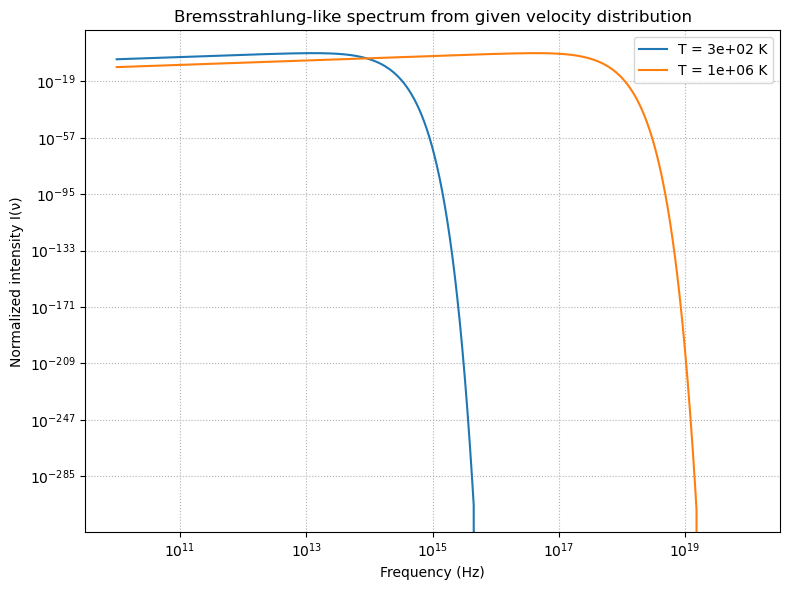

In [26]:
# Q6_spectrum_direct.py
# Radiation spectrum from given velocity distribution
# f(v) ∝ v^4 exp(-m v^2 / (2kT)) (1 + 0.3 m v^2 / kT)
# Spectrum: I(ν) ∝ f(v) * dv/dν, where ν = m v^2 / (2h)

import numpy as np
import matplotlib.pyplot as plt

# Physical constants (SI)
m = 9.10938356e-31      # electron mass, kg
k = 1.380649e-23         # Boltzmann constant, J/K
h = 6.62607015e-34       # Planck constant, J·s

def f_v(v, T):
    """Unnormalized velocity distribution"""
    return v**4 * np.exp(-m*v**2/(2*k*T)) * (1 + 0.3 * m*v**2/(k*T))

def spectrum(nu, T):
    """Spectral intensity I(nu) ∝ f(v)*dv/dnu"""
    v = np.sqrt(2*h*nu/m)
    dv_dnu = h / (m * v)
    return f_v(v, T) * dv_dnu

# Frequency range corresponding to electron speeds up to ~5e6 m/s (non-relativistic)
nu = np.logspace(10, 20, 500)  # frequency range (Hz)

# Temperatures
temps = [300, 1e6]
plt.figure(figsize=(8,6))

for T in temps:
    I = spectrum(nu, T)
    I /= np.max(I)  # normalize for comparison
    plt.loglog(nu, I, label=f"T = {T:.0e} K")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized intensity I(ν)")
plt.title("Bremsstrahlung-like spectrum from given velocity distribution")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.savefig("Q6_spectrum_plot.png", dpi=300)
plt.show()
